In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression

### 1. Process & Load Dataset

In [ ]:
!python ../scripts/preprocess.py

In [2]:
DATA_PATH = "../data/processed/modeling_dataset_2016_2018.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Severity2,CityState,Hour,Is_Weekend,Rain_Bucket,Weather_Group,Visibility_Bucket,Traffic_Signal
0,High,"Dayton, OH",5,False,Low,Rain,Clear,False
1,Low,"Reynoldsburg, OH",6,False,No Rain,Rain,Clear,False
2,Low,"Williamsburg, OH",6,False,No Rain,Other,Clear,True
3,High,"Dayton, OH",7,False,No Rain,Cloudy,Clear,False
4,Low,"Dayton, OH",7,False,No Rain,Cloudy,Moderate,True


In [3]:
df.isna().sum()

Severity2            0
CityState            0
Hour                 0
Is_Weekend           0
Rain_Bucket          0
Weather_Group        0
Visibility_Bucket    0
Traffic_Signal       0
dtype: int64

In [4]:
df["Severity2"].value_counts(normalize=True).mul(100).round(2)

Severity2
Low     65.82
High    34.18
Name: proportion, dtype: float64

### 2. Train/Test Split (Boston Holdout)

In [5]:
TEST_CITY = "Boston, MA"

train_df = df[df["CityState"] != TEST_CITY].copy()
test_df  = df[df["CityState"] == TEST_CITY].copy()

train_df.shape, test_df.shape

((405161, 8), (433, 8))

Sanity check

In [6]:
train_df["Severity2"].value_counts(normalize=True).round(2)

Severity2
Low     0.66
High    0.34
Name: proportion, dtype: float64

In [7]:
test_df["Severity2"].value_counts(normalize=True).round(2)

Severity2
Low     0.74
High    0.26
Name: proportion, dtype: float64

### 3. Feature Selection & Preprocessing
Our feature set is composed of the following:
- `Hour` (numeric)
- `Is_Weekend` (binary)
- `Traffic_Signal` (binary)
- `Rain_Bucket` (categorical)
- `Weather_Group` (categorical)
- `Visibility_Bucket` (categorical)

In [8]:
target = "Severity2"

groups = train_df["CityState"]

numeric_features = ["Hour"]
binary_features = ["Is_Weekend", "Traffic_Signal"]
categorical_features = ["Rain_Bucket", "Weather_Group", "Visibility_Bucket"]

X_train = train_df[numeric_features + binary_features + categorical_features]
y_train = (train_df[target] == "High").astype(int)  # 1=High

X_test = test_df[numeric_features + binary_features + categorical_features]
y_test = (test_df[target] == "High").astype(int)

Preprocessing

In [9]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features + binary_features),
    ],
    remainder="drop"
)

### 4. Validation: GroupKFold by City

In [18]:
def crossval_by_city(model, X_train, y_train, groups, n_splits=5):
    cv = GroupKFold(n_splits=n_splits)

    scoring = {
        "f1": "f1",
        "precision": "precision",
        "recall": "recall",
        "roc_auc": "roc_auc",
        "avg_precision": "average_precision",
    }

    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv, groups=groups,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
        error_score="raise"
    )

    out = (
        pd.DataFrame(cv_results)
          .filter(like="test_")
          .agg(["mean", "std"])
          .T
          .rename_axis("metric")
    )

    out.index = out.index.str.replace("test_", "", regex=False)
    
    return out

In [35]:
def evaluate_holdout(y_true, pred, proba=None):
    if proba is not None:
        print(f"Test ROC-AUC: {roc_auc_score(y_true, proba):.3f}")
        print(f"Test PR-AUC : {average_precision_score(y_true, proba):.3f}")
    
    print(f"Test F1     : {f1_score(y_true, pred):.3f}")
    print(f"Test Precision: {precision_score(y_true, pred):.3f}")
    print(f"Test Recall   : {recall_score(y_true, pred):.3f}")
    
    print("\nClassification report:")
    print(classification_report(y_true, pred, digits=3))

In [63]:
def plot_confusion_matrix(y_true, pred, normalize="true", figsize=(8,5)):
    cm = confusion_matrix(y_true, pred, normalize=normalize)

    plt.figure(figsize=figsize)

    labels = ["Low", "High"]

    sns.heatmap(
        cm, 
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels
    )

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Test Confusion Matrix')
    plt.tight_layout()
    plt.show()

### 5. Baseline Model: Logistic Regression

In [13]:
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=200, class_weight="balanced"))
])

In [19]:
crossval_by_city(logreg, X_train, y_train, groups)

,mean,std
metric,,
f1,0.546863,0.034668
precision,0.389930,0.033336
recall,0.917833,0.015102
roc_auc,0.614180,0.013486
avg_precision,0.435918,0.035851


In [24]:
logreg.fit(X_train, y_train)

proba = logreg.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

In [68]:
evaluate_holdout(y_test, pred, proba)

Test ROC-AUC: 0.643
Test PR-AUC : 0.369
Test F1     : 0.486
Test Precision: 0.350
Test Recall   : 0.795

Classification report:
              precision    recall  f1-score   support

           0      0.872     0.486     0.624       321
           1      0.350     0.795     0.486       112

    accuracy                          0.566       433
   macro avg      0.611     0.640     0.555       433
weighted avg      0.737     0.566     0.588       433



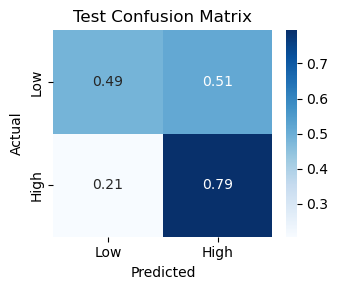

In [67]:
plot_confusion_matrix(y_test, pred, normalize="true", figsize=(3.5,3))